<span style="color:green;font-weight:bold">Commented version</span>

**Exercise 2**
by Sören Krüger, Leon Happ and Schant Demircian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn import model_selection
from sklearn.model_selection import KFold

**3 Data Preparation**

<span style="color:green;font-weight:bold">The data preperation is essentially the same, but without defining functions. Also the train-test-split is done in exercise 4 instead of 3.</span>

In [2]:
digits = load_digits()

print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [3]:
data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

In [4]:
args17 = np.array((target == 1) + (target == 7))
data17, images17, target17, target_names17 = data[args17], images[args17], target[args17], target_names[(target_names==1) | (target_names==7)]

**3.1 Dimension Reduction** 

<span style="color:green;font-weight:bold">This part is also essentially the same, but of course with other features</span>

<Figure size 432x288 with 0 Axes>

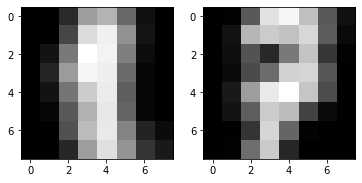

In [5]:
plt.gray()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.mean(images17[target17==1], axis=0))
ax2.imshow(np.mean(images17[target17==7], axis=0))
plt.show()

In [6]:
# A single pixel which is bright for 1 and dark for 7
firstarg = np.ravel_multi_index((2, 3), (8, 8))
# std of a line of pixels, which is small for 1 and large for 7
secondarg = np.ravel_multi_index((np.arange(0, 8), 4), (8, 8))

def reduce_dim(x):
    f1 = x[:, firstarg]
    f2 = np.std(x[:, secondarg], axis=1)
    
    return np.vstack((f1, f2)).T

**3.2 Scatterplot**

<span style="color:green;font-weight:bold">Again, essentially the same. We don't have a legend but the markers speak for themselves. We could have plotted a title, though</span>

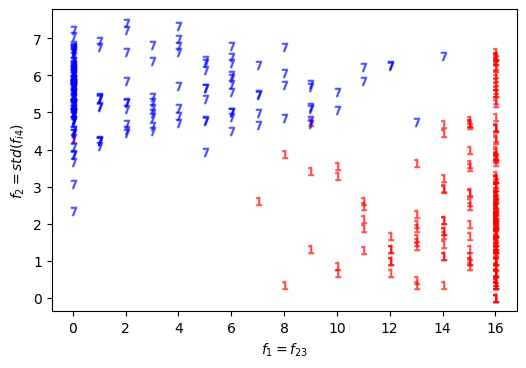

In [7]:
reduce17 = reduce_dim(data17)

plt.figure(dpi=100)
plt.scatter(reduce17[:, 0][target17==1], reduce17[:, 1][target17==1], c='red', alpha=0.5, marker='$1$')
plt.scatter(reduce17[:, 0][target17==7], reduce17[:, 1][target17==7], c='blue', alpha=0.5, marker='$7$')
plt.xlabel('$f_1 = f_{23}$')
plt.ylabel('$f_2 = std(f_{i4})$')
plt.show()

**4 Nearest Mean**

**4.1 Implement the nearest mean classifier**

<span style="color:green;font-weight:bold">The classifier also does essentially the same. We did not use a loop for the distance calculation, which could be faster for a large number of targets. Also, we don't return the means.</span>

In [8]:
# splitting training and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data17, target17, test_size = 2/5, random_state = 0)

reduce_X_train, reduce_X_test = reduce_dim(X_train), reduce_dim(X_test)

In [9]:
def dist_vec(training, test):
    '''Distance calculation between all training and test points'''
    A2 = np.sum(np.square(training), axis = 1)
    B2 = np.sum(np.square(test), axis = 1)
    AB = training@test.T
    return np.sqrt(A2[:, None] - 2*AB + B2)

def nearest_mean(training_features, training_labels, test_features):
    '''nearest mean classifier'''
    all_labels = np.unique(training_labels)
    train_means = np.array([np.mean(training_features[training_labels==x],
                                    axis=0) for x in all_labels])
    
    distances = dist_vec(train_means, test_features)
    min_distances = np.argmin(distances, axis=0)
    predicted_labels = all_labels[min_distances]
    
    return predicted_labels

In [10]:
print('classifiaction error:', np.sum((nearest_mean(reduce_X_train, y_train, reduce_X_test) - y_test) != 0)/len(y_test))

classifiaction error: 0.020689655172413793


**4.2 Visualize the decision regions**

<span style="color:green;font-weight:bold">Again, essentially the same</span>

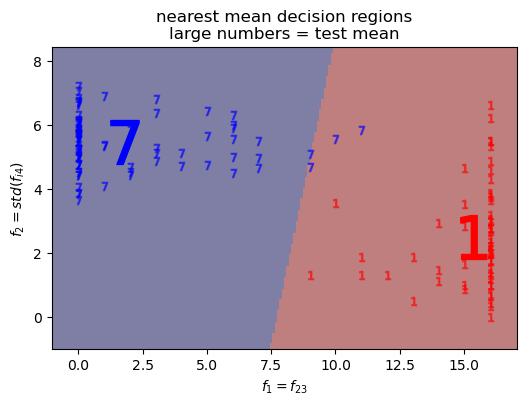

In [11]:
# get data point for the whole domain
f1_dummy = np.linspace(reduce_X_train[:, 0].min()-1, reduce_X_train[:, 0].max()+1, 200)
f2_dummy = np.linspace(reduce_X_train[:, 1].min()-1, reduce_X_train[:, 1].max()+1, 200)

# stack those data points
test1, test2 = np.meshgrid(f1_dummy, f2_dummy)
test12 = np.vstack((test1.flatten(), test2.flatten())).T

# predictions the data points
pred12 = nearest_mean(reduce_X_train, y_train, test12).reshape(200, 200)

plt.figure(dpi=100)
plt.pcolor(f1_dummy, f2_dummy, -pred12, cmap='seismic', alpha=.5, shading='nearest', snap=True)
plt.scatter(reduce_X_test[:, 0][y_test==1], reduce_X_test[:, 1][y_test==1], c='red', alpha=0.5, marker='$1$')
plt.scatter(reduce_X_test[:, 0][y_test==7], reduce_X_test[:, 1][y_test==7], c='blue', alpha=0.5, marker='$7$')

plt.scatter(np.mean(reduce_X_test[:, 0][y_test==1]), np.mean(reduce_X_test[:, 1][y_test==1]), c='red', s=1000, marker='$1$')
plt.scatter(np.mean(reduce_X_test[:, 0][y_test==7]), np.mean(reduce_X_test[:, 1][y_test==7]), c='blue', s=1000, marker='$7$')

plt.xlabel('$f_1 = f_{23}$')
plt.ylabel('$f_2 = std(f_{i4})$')
plt.title('nearest mean decision regions\nlarge numbers = test mean')
plt.show()

**5. QDA**

<span style="color:green;font-weight:bold">The fit_qda function does essentially the same. We use three list comprehensions instead of one loop, not sure which one is faster.</span>

**5.1 Implement QDA Training**

In [12]:
def fit_qda(training_features, training_labels):
    '''fit qda and return mu, covmat and p'''
    N = len(training_labels)
    all_labels = np.sort(np.unique(training_labels))
    
    mu = np.array([np.mean(training_features[training_labels==x],
                                    axis=0) for x in all_labels]).T
    
    covmat = np.array([np.cov(training_features[training_labels==x].T
                             ) for x in all_labels]).T
    
    p = np.array([N/np.sum(training_labels==x) for x in all_labels])
    
    return mu, covmat, p

**5.2 Implement QDA prediction**

<span style="color:green;font-weight:bold">Well this does the same calculation but in a pretty different way. I still think that both versions should perform similarly because both use only one loop. </span>

In [13]:
def predict_qda(mu, covmat, p, test_features):
    '''predict test set with given fit'''
    k = len(p) # number of labels
    D = mu.shape[0] # number of featues per instance
    
    dist = np.array([0.5*np.einsum('ij,ij->i', (test_features - mu[:, i])@
                np.linalg.inv(covmat[:,:,i]), (test_features - mu[:, i])) +
                     0.5*np.log(np.linalg.det(2*np.pi*covmat[:,:,i])) -
                         np.log(p[i]) for i in range(k)])
    pred_arg = np.argmin(dist, axis=0)
    
    return pred_arg

In [14]:
print('wrong classifications:', np.sum(target_names17[predict_qda(*fit_qda(reduce_X_train, y_train),
                                                    reduce_X_test)] - y_test))

wrong classifications: 0


**5.3 Visualization**

<span style="color:green;font-weight:bold">Again, the plot is essentially the same.</span>

In [15]:
def gaussian(x, mu, cov):
    '''Multivariate Gaussian function'''
    return np.exp(-np.einsum('ij,ij->i', (x - mu)@np.linalg.inv(cov), (x - mu)))

In [16]:
pred_qda_200 = predict_qda(*fit_qda(reduce_X_train, y_train), test12).reshape(200, 200)
mymu, mycovmat, myp = fit_qda(reduce_X_train, y_train)

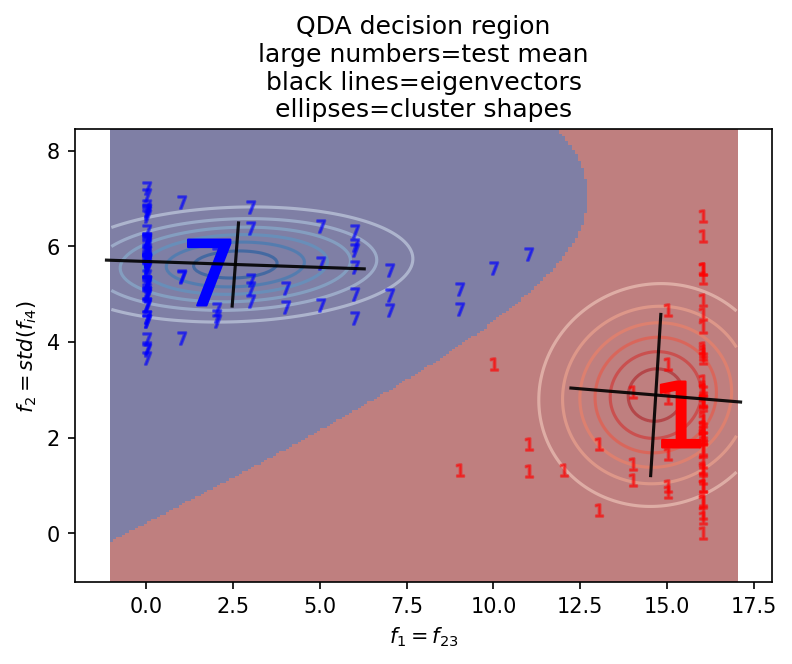

In [17]:
plt.figure(dpi=150)
plt.pcolor(f1_dummy, f2_dummy, -pred_qda_200, cmap='seismic', alpha=.5, shading='nearest', snap=True)

ct1 = plt.contour(f1_dummy, f2_dummy, gaussian(test12, mymu[0], mycovmat[:, :, 0]).reshape(200, 200), zorder=1, cmap='Reds', alpha=.5)
plt.contour(f1_dummy, f2_dummy, gaussian(test12, mymu[1], mycovmat[:, :, 1]).reshape(200, 200), zorder=1, cmap='Blues', alpha=.5)

plt.scatter(reduce_X_test[:, 0][y_test==1], reduce_X_test[:, 1][y_test==1], c='red', alpha=0.5, marker='$1$', zorder=1)
plt.scatter(reduce_X_test[:, 0][y_test==7], reduce_X_test[:, 1][y_test==7], c='blue', alpha=0.5, marker='$7$', zorder=2)

plt.scatter(np.mean(reduce_X_test[:, 0][y_test==1]), np.mean(reduce_X_test[:, 1][y_test==1]), c='red', s=1000, marker='$1$')
plt.scatter(np.mean(reduce_X_test[:, 0][y_test==7]), np.mean(reduce_X_test[:, 1][y_test==7]), c='blue', s=1000, marker='$7$')

for i in range(2):
    eigval, eigvec = np.linalg.eig(mycovmat[:,:,i])
    veclen1 = np.sqrt(eigval[0])
    veclen2 = np.sqrt(eigval[1])
    for j in range(2):
        veclen = np.sqrt(eigval)
        x1, y1 = mymu[i][0], mymu[i][1]
        x2, y2 = eigvec[j][0]*veclen1, eigvec[j][1]*veclen[j]
        plt.plot([x1-x2, x1+x2], [y1-y2, y1+y2], c='black', alpha=.9)
    
    
plt.xlabel('$f_1 = f_{23}$')
plt.ylabel('$f_2 = std(f_{i4})$')
plt.title('QDA decision region\nlarge numbers=test mean\nblack lines=eigenvectors\nellipses=cluster shapes')
plt.show()

**5.4 Performance evaluation**  
Will be at the end

**LDA**

<span style="color:green;font-weight:bold">LDA is (again) essentially the same. We compute all covariance matrices and use the mean instead of calculating one global covariance, which could be faster. In the plot, we completely forget the contour plot and the eigenvectors. For the cross validation, we used one function which takes the classifier as an argument instead of using two seperate functions.</span>

In [18]:
def fit_lda(training_features, training_labels):
    '''Exactly the same as QDA, but with mean covariance'''
    N = len(training_labels)
    all_labels = np.sort(np.unique(training_labels))
    
    mu = np.array([np.mean(training_features[training_labels==x],
                                    axis=0) for x in all_labels]).T
    
    covmat = np.array([np.cov(training_features[training_labels==x].T
                             ) for x in all_labels]).T
    
    
    covmat = np.mean(covmat, axis=-1)
    p = np.array([N/np.sum(training_labels==x) for x in all_labels])
    
    return mu, covmat, p

In [19]:
def predict_lda(mu, covmat, p, test_features):
    '''Exactly the same as QDA, but for fit_lda'''
    k = len(p) # number of labels
    D = mu.shape[0] # number of featues per instance
    
    dist = np.array([0.5*np.einsum('ij,ij->i', (test_features - mu[:, i])@
                np.linalg.inv(covmat), (test_features - mu[:, i])) +
                     0.5*np.log(np.linalg.det(2*np.pi*covmat)) -
                         np.log(p[i]) for i in range(k)])
    pred_arg = np.argmin(dist, axis=0)
    
    return pred_arg

In [20]:
print('wrong classifications:', np.sum((predict_lda(*fit_lda(reduce_X_train, y_train),
                                                    reduce_X_test)*6)+1 - y_test))

wrong classifications: 0


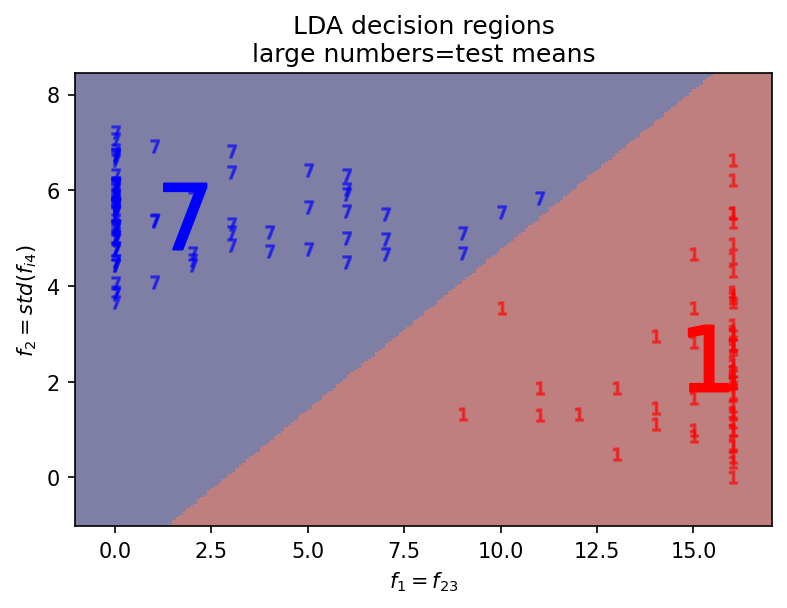

In [21]:
pred_qda_200 = predict_lda(*fit_lda(reduce_X_train, y_train), test12).reshape(200, 200)
mymu, mycovmat, myp = fit_lda(reduce_X_train, y_train)

plt.figure(dpi=150)
plt.pcolor(f1_dummy, f2_dummy, -pred_qda_200, cmap='seismic', alpha=.5, shading='nearest', snap=True)

plt.scatter(reduce_X_test[:, 0][y_test==1], reduce_X_test[:, 1][y_test==1], c='red', alpha=0.5, marker='$1$', zorder=1)
plt.scatter(reduce_X_test[:, 0][y_test==7], reduce_X_test[:, 1][y_test==7], c='blue', alpha=0.5, marker='$7$', zorder=2)

plt.scatter(np.mean(reduce_X_test[:, 0][y_test==1]), np.mean(reduce_X_test[:, 1][y_test==1]), c='red', s=1000, marker='$1$')
plt.scatter(np.mean(reduce_X_test[:, 0][y_test==7]), np.mean(reduce_X_test[:, 1][y_test==7]), c='blue', s=1000, marker='$7$')

    
plt.xlabel('$f_1 = f_{23}$')
plt.ylabel('$f_2 = std(f_{i4})$')
plt.title('LDA decision regions\nlarge numbers=test means')
plt.show()

Cross validation

In [22]:
def cross_validate(fit_func, predict_func, X, y, L, random_state=0):
    kf = KFold(n_splits=L, random_state=random_state, shuffle=True)
    kf.get_n_splits(X)
    labels = np.sort(np.unique(y))
    
    errors = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pars = fit_func(X_train, y_train)
        predictions = labels[predict_func(*pars, X_test)]
        err = np.sum((predictions-y_test)!=0)/len(y_test)
        errors.append(err)
    
    return np.mean(errors)

In [23]:
CV_QDA = 0
CV_LDA = 0
for i in range(100):
    CV_QDA += cross_validate(fit_qda, predict_qda, reduce_dim(data17), target17, 10, i)
    CV_LDA += cross_validate(fit_lda, predict_lda, reduce_dim(data17), target17, 10, i)

print('Cross validated QDA error: {:.3f}%'.format(CV_QDA))
print('Cross validated LDA error: {:.3f}%'.format(CV_LDA))

Cross validated QDA error: 2.004%
Cross validated LDA error: 2.530%
